Generating dataset...
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8973 - loss: 0.7547 - val_accuracy: 1.0000 - val_loss: 2.4704e-14
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3215e-14 - val_accuracy: 1.0000 - val_loss: 4.7025e-16
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8118e-16 - val_accuracy: 1.0000 - val_loss: 4.4447e-16
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1315e-16 - val_accuracy: 1.0000 - val_loss: 4.4381e-16
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0963e-16 - val_accuracy: 1.0000 - val_loss: 4.4380e-16
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1618e-16 - val_accuracy: 1.0000 - val_loss: 4.4380e-16
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8091e-16 - val_accuracy: 1.0000 - val_loss: 4.4380e-16
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0

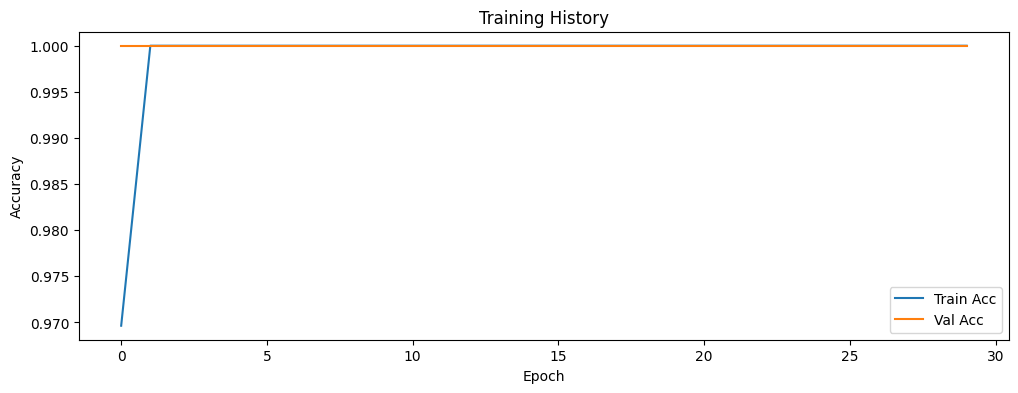

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6387e-15  
Test Accuracy: 100.00%
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


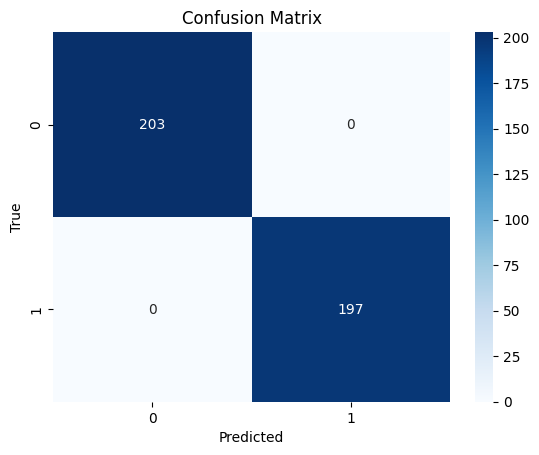

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       203
           1       1.00      1.00      1.00       197

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

Predicting on new data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


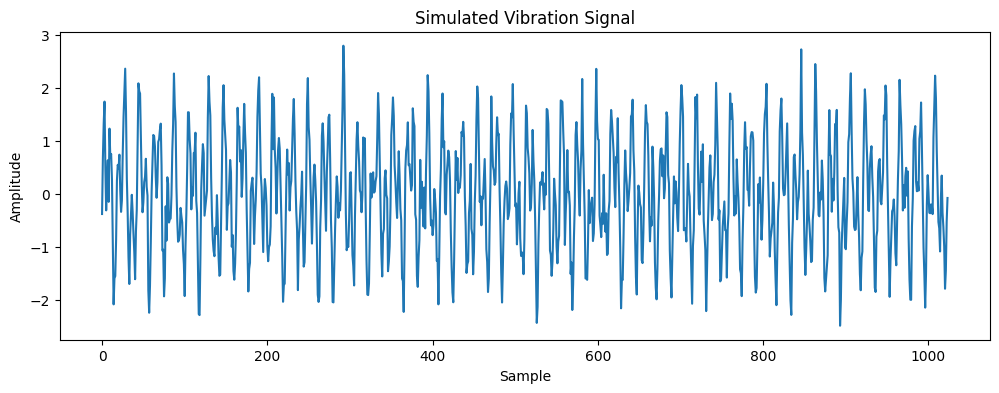

🟢 Structure Status: HEALTHY!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from scipy.fft import fft
import seaborn as sns

# ==== SIMULATE VIBRATION SENSOR DATA ====
def simulate_vibration(samples=1024, damage=False):
    t = np.linspace(0, 1, samples)
    signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)

    if damage:
        signal += np.sin(2 * np.pi * 250 * t)  # damage signature

    noise = 0.3 * np.random.randn(samples)
    signal += noise
    return signal

# ==== GENERATE DATASET ====
def generate_dataset(num_samples=2000):
    X, y = [], []

    for _ in range(num_samples // 2):
        sig = simulate_vibration(damage=False)
        sig_fft = np.abs(fft(sig))[:len(sig)//2]
        X.append(sig_fft)
        y.append(0)  # Undamaged

        sig = simulate_vibration(damage=True)
        sig_fft = np.abs(fft(sig))[:len(sig)//2]
        X.append(sig_fft)
        y.append(1)  # Damaged

    return np.array(X), np.array(y)

# ==== BUILD MODEL ====
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# ==== TRAIN AND EVALUATE ====
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model(X_train.shape[1])
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.3)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(y_test, y_pred))
    return model

# ==== PREDICT NEW DATA ====
def predict_structure(model):
    signal = simulate_vibration(damage=np.random.rand() > 0.5)
    signal_fft = np.abs(fft(signal))[:len(signal)//2]
    signal_fft = signal_fft / np.max(signal_fft)

    prediction = model.predict(signal_fft.reshape(1, -1))

    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title('Simulated Vibration Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

    if prediction[0][0] > 0.5:
        print("🔴 Structure Status: DAMAGED!")
    else:
        print("🟢 Structure Status: HEALTHY!")

# ==== MAIN ====
def main():
    print("Generating dataset...")
    X, y = generate_dataset()

    print("Training model...")
    model = train_and_evaluate(X, y)

    print("Predicting on new data...")
    predict_structure(model)

if __name__ == '__main__':
    main()